# Activity 4: Building an ANN

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# get data
data = pd.read_csv('dccc_prepared.csv')

In [3]:
data.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
1,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
2,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,...,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0
3,0.040404,0.166667,0.666667,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.178407,0.100102,0.276367,0.002862,0.001078,0.000733,0.001610,0.002345,0.001513,0
4,0.494949,0.166667,0.666667,0.137931,0.2,0.2,0.2,0.2,0.2,0.2,...,0.671310,0.559578,0.625196,0.062961,0.023749,0.042409,0.032591,0.032237,0.026047,0


In [4]:
# seperate features and label
X = data.iloc[:,0:-1]
Y = data.iloc[:, -1]

# split data
x_new, x_test, y_new, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)
dev_perc = x_test.shape[0]/x_new.shape[0]
x_train, x_dev, y_train, y_dev = train_test_split(x_new, y_new, test_size=dev_perc, random_state=0)
print(x_train.shape,y_train.shape, x_dev.shape, y_dev.shape, x_test.shape, y_test.shape)

(28036, 22) (28036,) (9346, 22) (9346,) (9346, 22) (9346,)


In [5]:
# convert tensor

x_dev = torch.Tensor(x_dev.values).float()
y_dev = torch.Tensor(y_dev.values).long()

x_test = torch.Tensor(x_test.values).float()
y_test = torch.Tensor(y_test.values).long()

In [6]:
# develop model
class SoftmaxClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden1 = nn.Linear(input_size, 10)
        self.hidden2 = nn.Linear(10,10)
        self.hidden3 = nn.Linear(10, 10)
        self.output = nn.Linear(10,2)
        
    def forward(self, x):
        z = F.relu(self.hidden1(x))
        z = F.relu(self.hidden2(z))
        z = F.relu(self.hidden3(z))
        out = F.log_softmax(self.output(z), dim=1)
        
        return out

In [7]:
# setup training variables
model = SoftmaxClassifier(x_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# train
epochs= 50
batch_size = 128

train_losses, train_acc, dev_losses, dev_acc = [],[],[],[]

for e in range(epochs):
    x_shuffle, y_shuffle = shuffle(x_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    for i in range(0, len(x_shuffle), batch_size):
        iterations += 1
        batch_end = i + batch_size
        
        # batches
        x_batch = torch.Tensor(x_shuffle.iloc[i:batch_end,:].values).float()
        y_batch = torch.Tensor(y_shuffle.iloc[i:batch_end].values).long()
        
        # training
        log_ps = model(x_batch)
        loss = criterion(log_ps, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
        
        # dev
        with torch.no_grad():
            dev_log_ps = model(x_dev)
            dev_loss = criterion(dev_log_ps, y_dev)
            
            dev_ps = torch.exp(dev_log_ps)
            dev_top_p, dev_top_class = dev_ps.topk(1, dim=1)
            dev_acc_score = accuracy_score(y_dev, dev_top_class)
            
            # add to lists
            train_losses.append(running_loss/iterations)
            dev_losses.append(dev_loss)
            train_acc.append(running_acc/iterations)
            dev_acc.append(dev_acc_score)
            
    print(f'e:{e+1}/{epochs}, Train Loss:{running_loss/iterations}, Dev Loss:{dev_loss}, Train Acc:{running_acc/iterations}, dev_acc:{dev_acc_score}')

e:1/50, Train Loss:0.6649600890549746, Dev Loss:0.6215672492980957, Train Acc:0.6078835227272728, dev_acc:0.6622084314145089
e:2/50, Train Loss:0.6081916153430938, Dev Loss:0.6006588935852051, Train Acc:0.6678267045454546, dev_acc:0.6744061630644126
e:3/50, Train Loss:0.5924536531621759, Dev Loss:0.5917433500289917, Train Acc:0.6861860795454545, dev_acc:0.689278835865611
e:4/50, Train Loss:0.5854694539850408, Dev Loss:0.5885565280914307, Train Acc:0.700497159090909, dev_acc:0.6981596404879092
e:5/50, Train Loss:0.5842717938802459, Dev Loss:0.5911300778388977, Train Acc:0.6992542613636363, dev_acc:0.6956986946287181
e:6/50, Train Loss:0.5819449752569199, Dev Loss:0.585774838924408, Train Acc:0.7009588068181818, dev_acc:0.6991226193023754
e:7/50, Train Loss:0.5811645950783383, Dev Loss:0.5855164527893066, Train Acc:0.7004261363636364, dev_acc:0.6983736357800129
e:8/50, Train Loss:0.580653064223853, Dev Loss:0.5844360589981079, Train Acc:0.7014914772727273, dev_acc:0.6976246522576504
e:9/

In [10]:
print(f'Final:\nTrain Loss:{train_losses[-1]}, Dev Loss:{dev_losses[-1]}, Train Acc:{train_acc[-1]}, dev_acc:{dev_acc[-1]}')

Final:
Train Loss:0.5610798166556792, Dev Loss:0.5654328465461731, Train Acc:0.7114346590909091, dev_acc:0.705328482773379


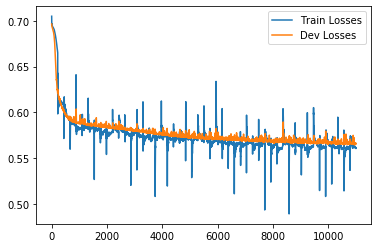

In [11]:
plt.plot(train_losses, label='Train Losses')
plt.plot(dev_losses, label='Dev Losses')
plt.legend()

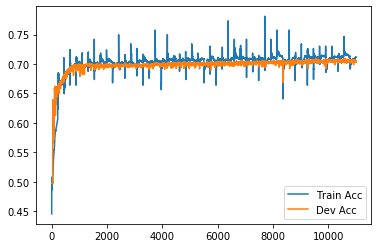

In [12]:
plt.plot(train_acc, label='Train Acc')
plt.plot(dev_acc, label='Dev Acc')
plt.legend()